In [39]:
import numpy as np
import cupy as cp
from holotomocupy.holo import G, GT
from holotomocupy.shift import S, ST
from holotomocupy.chunking import gpu_batch
from holotomocupy.recon_methods import CTFPurePhase, multiPaganin
from holotomocupy.proc import dai_yuan, linear
import holotomocupy.chunking as chunking
from holotomocupy.utils import *



# Init data sizes and parametes of the PXM of ID16A

In [40]:
n = 512  # object size in each dimension

noise = 0
z1c = -19.5e-3
# thickness of the coded aperture
code_thickness = 1.8e-6 #in m
# feature size
ill_feature_size = 2e-6 #in m

# ntheta = int(sys.argv[1])  # number of angles (rotations)
# noise = int(sys.argv[2])#sys.argv[2]=='True'
# z1c = float(sys.argv[3])  # positions of the code and the probe for reconstruction

center = n/2 # rotation axis
npos = 49  # number of code positions
detector_pixelsize = 3e-6
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = z1c
z1 = np.tile(z1, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = np.abs(detector_pixelsize/magnifications[0]*2048/n)  # object voxel size
# allow padding if there are shifts of the probe
pad = n//8
# sample size after demagnification
ne = 1200+2*pad

show = True

flg = f'{n}_{1}_{npos}_{z1c}_{noise}_code'
path = f'/data2/vnikitin/nfp_codes'

## Read data

In [41]:
data00 = np.zeros([1, npos, n, n], dtype='float32')
ref0 = np.zeros([1, npos, n, n], dtype='float32')
print(f'{path}/data/data_{0}_{flg}.tiff')
for k in range(npos):
    data00[:, k] = read_tiff(f'{path}/data/data_{k}_{flg}.tiff')[:1]
for k in range(npos):
    ref0[:, k] = read_tiff(f'{path}/data/ref_{k}_{flg}.tiff')[:]
code = np.load(f'{path}/data/code_{flg}.npy')
shifts_code = np.load(f'{path}/data/shifts_code_{flg}.npy')[:, :npos]



/data2/vnikitin/nfp_codes/data/data_0_512_1_49_-0.0195_0_code.tiff


# Construct operators


In [42]:
def Lop(psi):
    psi = cp.array(psi)

    data = cp.zeros([psi.shape[0], npos, n, n], dtype='complex64')
    for i in range(npos):
        psir = psi[:,i].copy()       
        psir = G(psir, wavelength, voxelsize, distances[i])
        data[:, i] = psir[:, pad:n+pad, pad:n+pad]
    return data

def LTop(data):
    psi = cp.zeros([data.shape[0],npos, n+2*pad, n+2*pad], dtype='complex64')

    for j in range(npos):
        psir = cp.pad(data[:, j], ((0, 0), (pad, pad), (pad, pad))).astype('complex64')
        psir = GT(psir, wavelength, voxelsize, distances[j])        
        psi[:,j] = psir
    return psi

def Lop2(prb):
    prb = cp.array(prb)
    psir = G(prb, wavelength, voxelsize, distances[0],'symmetric')
    data = psir[:, pad:n+pad, pad:n+pad]
    return data

def LTop2(data):
    data= cp.array(data)
    data = cp.pad(data, ((0, 0), (pad, pad), (pad, pad))).astype('complex64')
    psi = GT(data, wavelength, voxelsize, distances[0],'symmetric')
    return psi

def Sop(psi):
    psi = cp.array(psi)

    data = cp.zeros([psi.shape[0], npos, n+2*pad, n+2*pad], dtype='complex64')
    for i in range(npos):
        psir = psi.copy()
    
        # shift and crop the code 
        psir = S(psir, shifts_code[:, i])
        nee = psir.shape[1]        
        data[:,i] = psir[:, nee//2-n//2-pad:nee//2+n//2+pad, nee//2-n//2-pad:nee//2+n//2+pad]
    return data

def STop(data):
    psi = cp.zeros([data.shape[0], ne, ne], dtype='complex64')

    for j in range(npos):
        psir = cp.pad(data[:,j],((0,0),(ne//2-n//2-pad,ne//2-n//2-pad),(ne//2-n//2-pad,ne//2-n//2-pad)))        
        psi += ST(psir,shifts_code[:,j])
    return psi


data = cp.array(data00)
arr1 = cp.pad(data[:,0],((0,0),(ne//2-n//2,ne//2-n//2),(ne//2-n//2,ne//2-n//2)),'symmetric')     
prb1 = cp.ones([1,n+2*pad,n+2*pad],dtype='complex64')
shifts_code = cp.array(shifts_code)
arr2 = Sop(arr1)
arr3 = STop(arr2)

arr4 = Lop(arr2)
arr5 = LTop(arr4)

arr6 = Lop2(prb1)
arr7 = LTop2(arr6)


print(f'{cp.sum(arr1*cp.conj(arr3))}==\n{cp.sum(arr2*cp.conj(arr2))}')
print(f'{cp.sum(arr2*cp.conj(arr5))}==\n{cp.sum(arr4*cp.conj(arr4))}')
print(f'{cp.sum(prb1*cp.conj(arr7))}==\n{cp.sum(arr6*cp.conj(arr6))}')



(23553720+1.443875789642334j)==
(23553720-1.5848499596016197e-11j)
(15706361-0.1342606544494629j)==
(15706361+4.0612278098706156e-05j)
(262143.984375+3.0514318495988846e-05j)==
(262144+0j)


### Divide by reference image for 1step Paganin reconsturction

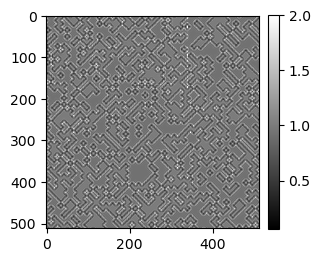

In [43]:
ref0 = cp.array(ref0)
data00 = cp.array(data00)

rdata = data00/ref0
mshow((rdata)[0,0],show,vmax=2)

/tmp/ipykernel_894727/3561898921.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  recMultiPaganin[:,j] = ST(r,shifts_code[:,j])
/tmp/ipykernel_894727/3561898921.py:10: ComplexWarning: Casting complex values to real discards the imaginary part
  recMultiPaganinr[:,j] = ST(rr,shifts_code[:,j])


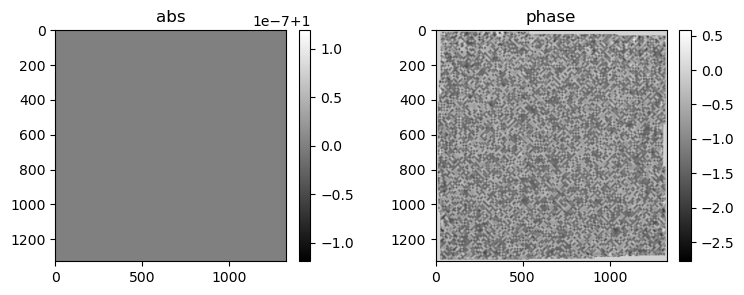

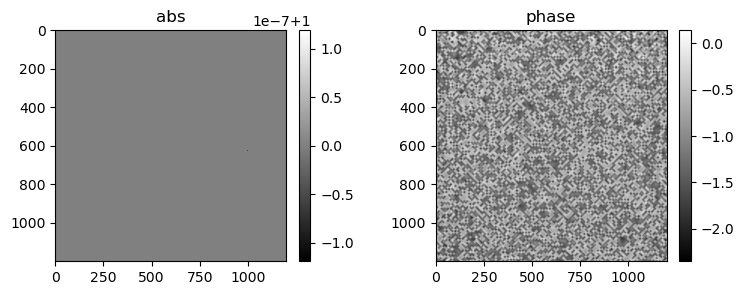

In [44]:
recMultiPaganin = cp.zeros([1,npos,ne,ne],dtype='float32')
recMultiPaganinr = cp.zeros([1,npos,ne,ne],dtype='float32')# to compensate for overlap
for j in range(0,npos):
    r = multiPaganin(rdata[:,j:j+1],
                         distances[j:j+1], wavelength, voxelsize,  24.05, 5e-2)    
    rr = r*0+1 # to compensate for overlap
    r = cp.pad(r,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)),'constant')   
    rr = cp.pad(rr,((0,0), (ne//2-n//2,ne//2-n//2), (ne//2-n//2,ne//2-n//2)),'constant')   
    recMultiPaganin[:,j] = ST(r,shifts_code[:,j])
    recMultiPaganinr[:,j] = ST(rr,shifts_code[:,j])
    
recMultiPaganin = cp.sum(recMultiPaganin,axis=1)
recMultiPaganinr = cp.sum(recMultiPaganinr,axis=1)

# avoid division by 0
recMultiPaganinr[np.abs(recMultiPaganinr)<5e-2] = 1

# compensate for overlap
recMultiPaganin /= recMultiPaganinr
recMultiPaganin = cp.exp(1j*recMultiPaganin)

mshow_polar(recMultiPaganin[0],show)
mshow_polar(recMultiPaganin[0,pad:-pad,pad:-pad],show)


#### Reconstruction with the CG (Carlsson) with Hessians

### $\frac{1}{2}\mathcal{H}|_{x_0}(y,z)= \left\langle \mathbf{1}-d_{0}, \mathsf{Re}({L(q\cdot S(y))}\overline{L(q\cdot S(z))})\right\rangle+\left\langle d_{0},(\mathsf{Re}(\overline{l_0}\cdot L(q\cdot S(y))))\cdot (\mathsf{Re} (\overline{l_0}\cdot L(q\cdot S(z))))\right\rangle.$

### $ d_0 = d/|L(q\cdot S(x_0))+D(q)|$ ###
### $l_0=\frac{L(q\cdot S(x_0))+D(q)}{|L(q\cdot S(x_0))+D(q)|}$ ###


In [45]:
def hessian2(psi,ksi,eta,data,prb):
    hpsi = Sop(psi)*prb            
    hksi = Sop(ksi)*prb
    heta = Sop(eta)*prb

    Lksi = Lop(hksi)
    Leta = Lop(heta)
    Lpsi = Lop(hpsi) 
    Lprb = Lop2(prb)      

    d0 = data/cp.abs(Lpsi+Lprb)    
    l0 = (Lpsi+Lprb)/cp.abs(Lpsi+Lprb)    
    v1 = cp.sum((1-d0)*cp.real(Lksi*cp.conj(Leta)))
    v2 = cp.sum(d0*(cp.real(cp.conj(l0)*Lksi)*cp.real(cp.conj(l0)*Leta)))
    return 2*(v1+v2) 

### $\nabla F|_{x_0}=2 S^*( \bar q\cdot L^*\left( L(q\cdot S(x_0))-\tilde d\right)).$
### $\tilde d=d\cdot{l_0}-D(q)$ ###
### $l_0=\frac{L(q\cdot S(x_0))+D(q)}{|L(q\cdot S(x_0))+D(q)|}$ ###

In [46]:
def gradient(psi,prb,data):
    l0 = Lop(Sop(psi)*prb)+Lop2(prb)
    l0 = l0/cp.abs(l0)
    tdata = data*l0-Lop2(prb)
    gradx = 2*LTop(Lop(Sop(psi)*prb)-tdata)
    gradpsi = STop(gradx*cp.conj(prb))
    return gradpsi  

###  $ H|_{x_0}(z) =  2L^*\left(L(z)+\left({{l_0}\cdot (\mathcal{Re} (\overline{l_0}\cdot L(z)))}-{{ L(z)}}\right)\cdot d_0\right)$




In [47]:
def Hop(eta,psi,prb,data):
    hpsi = Sop(psi)*prb     
    heta = Sop(eta)*prb
    Lpsi = Lop(hpsi) 
    Leta = Lop(heta)
    Lprb = Lop2(prb)    
    
    d0 = data/cp.abs(Lpsi+Lprb)    
    l0 = (Lpsi+Lprb)/cp.abs(Lpsi+Lprb)    
    h = 2*LTop(Leta+(l0*cp.real(cp.conj(l0)*Leta)-Leta)*d0)
    h = STop(h*cp.conj(prb))
    return h


In [79]:

def newton(psi,grad,eta,prb,data):
    def minf(eta):
        return cp.linalg.norm(Hop(eta,psi,prb,data)-grad)**2
     
    for i in range(8):
        gradG = 2*Hop(Hop(eta,psi,prb,data)-grad,psi,prb,data)
        # etaG = -gradG
        
        # a = Hop(etaG,psi,prb,data)
        # b = Hop(a,psi,prb,data)

        # print(cp.sum(a*cp.conj(a)))
        # print(cp.sum(b*cp.conj(etaG)))
        if i==0:
            etaG = -gradG
        else:
            h2u = 2*cp.sum(Hop(Hop(gradG,psi,prb,data),psi,prb,data)*cp.conj(etaG))
            # h2u2 = 2*cp.sum(cp.conj(Hop(Hop(etaG,psi,prb,data),psi,prb,data))*gradG)
            # print('!',h2u-h2u2)
            h2b = 2*cp.sum(Hop(Hop(etaG,psi,prb,data),psi,prb,data)*cp.conj(etaG))            
            beta = h2u/h2b            
            etaG = -gradG + beta*etaG
                     
        #     etaG = -gradG + beta*etaG
        h2u = -cp.sum(cp.real(gradG*cp.conj(etaG)))
        h2b = 2*cp.sum(cp.real(etaG*cp.conj(Hop(Hop(etaG,psi,prb,data),psi,prb,data))))    
        #h2b2 = 2*cp.sum(cp.real(cp.conj(etaG)*Hop(Hop(etaG,psi,prb,data),psi,prb,data)))    
        gammah = h2u/h2b   
        eta+=gammah*etaG
        #print(i,gammah,minf(eta))
    return eta

0) gammah=array(0.1380201, dtype=float32), err=4.42392e+04


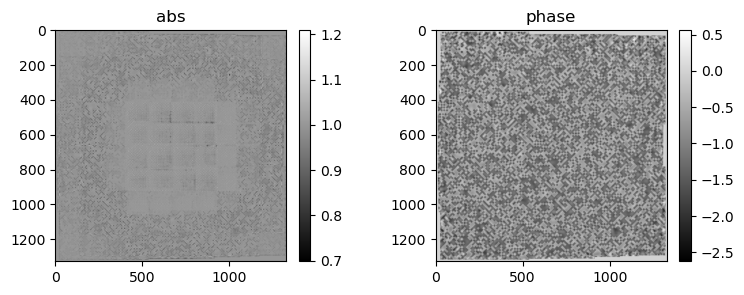

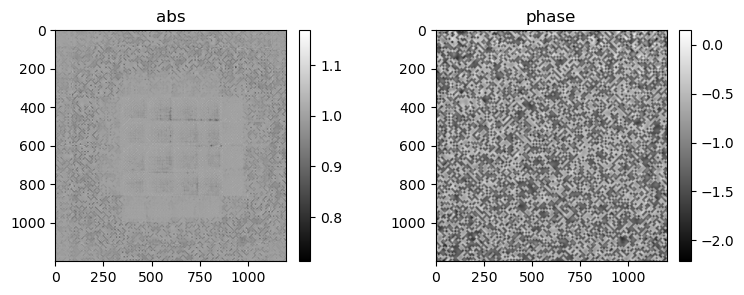

1) gammah=array(0.26221612, dtype=float32), err=2.81346e+04
2) gammah=array(0.14922409, dtype=float32), err=2.04736e+04
3) gammah=array(0.08996717, dtype=float32), err=1.35167e+04
4) gammah=array(0.5254015, dtype=float32), err=7.02599e+03
5) gammah=array(0.14971374, dtype=float32), err=5.47436e+03
6) gammah=array(0.27273083, dtype=float32), err=4.00968e+03
7) gammah=array(0.13855802, dtype=float32), err=3.18239e+03
8) gammah=array(0.34928703, dtype=float32), err=2.30819e+03
9) gammah=array(0.13132834, dtype=float32), err=1.85604e+03
10) gammah=array(0.5713194, dtype=float32), err=1.25475e+03
11) gammah=array(0.12533236, dtype=float32), err=1.03959e+03
12) gammah=array(0.4778673, dtype=float32), err=8.67575e+02
13) gammah=array(0.15406421, dtype=float32), err=7.92278e+02
14) gammah=array(0.32723117, dtype=float32), err=7.06983e+02
15) gammah=array(0.16385639, dtype=float32), err=6.48890e+02
16) gammah=array(0.3577625, dtype=float32), err=5.89227e+02
17) gammah=array(0.18125157, dtype=fl

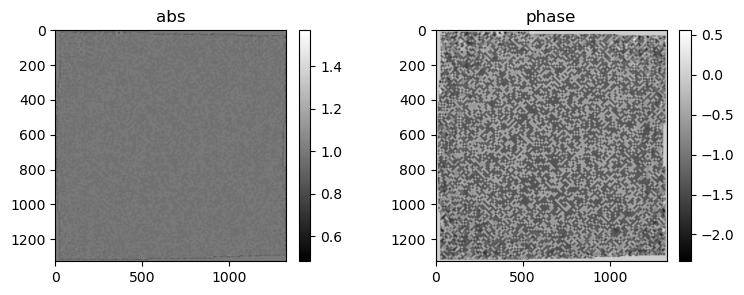

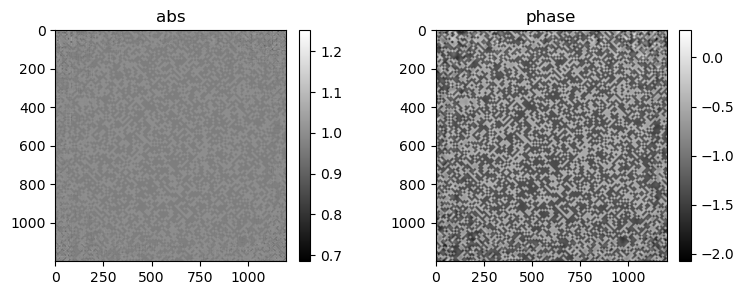

33) gammah=array(0.19512574, dtype=float32), err=2.16365e+02
34) gammah=array(0.1837684, dtype=float32), err=2.09796e+02
35) gammah=array(0.2147461, dtype=float32), err=2.03373e+02
36) gammah=array(0.17994183, dtype=float32), err=1.97785e+02
37) gammah=array(0.34480414, dtype=float32), err=1.90269e+02
38) gammah=array(0.15324531, dtype=float32), err=1.85123e+02
39) gammah=array(0.25203046, dtype=float32), err=1.80070e+02
40) gammah=array(0.15197176, dtype=float32), err=1.75487e+02
41) gammah=array(0.28699887, dtype=float32), err=1.70658e+02
42) gammah=array(0.15580358, dtype=float32), err=1.66275e+02
43) gammah=array(0.30880773, dtype=float32), err=1.61759e+02
44) gammah=array(0.63733846, dtype=float32), err=1.52648e+02
45) gammah=array(0.17497526, dtype=float32), err=1.48629e+02
46) gammah=array(0.2062298, dtype=float32), err=1.44940e+02
47) gammah=array(0.19318427, dtype=float32), err=1.41472e+02
48) gammah=array(0.22310962, dtype=float32), err=1.38187e+02
49) gammah=array(0.19636686

In [80]:
def cg_holo(data,ref, init_psi,init_prb,  pars):
    """Conjugate gradients method for holography"""
    # minimization functional
    def minf(fpsi):
        f = np.linalg.norm(np.abs(fpsi)-data)**2
        return f

    data = np.sqrt(data)
    ref = np.sqrt(ref)
    psi = init_psi.copy()
    prb = init_prb.copy()

    conv = np.zeros(pars['niter'])
    gammaha = np.zeros(pars['niter'])
    gammah = 0       
        
    for i in range(pars['niter']):                                        
        
        gradpsi = gradient(psi,prb, data)
        
        
        # if i==0:
        #     etapsi = -gradpsi
        # else:
        #     # top
        #     h2u = hessian2(psi,gradpsi,etapsi,data,prb)
        #     # bottom
        #     h2b = hessian2(psi,etapsi,etapsi,data,prb)            
        #     beta = h2u/h2b            
        #     etapsi = -gradpsi + beta*etapsi

        etapsi = -gradpsi
        etapsi = newton(psi, -gradpsi, etapsi, prb, data)   

        h2u = -cp.sum(cp.real(gradpsi*cp.conj(etapsi)))
        h2b = hessian2(psi,etapsi,etapsi,data,prb)    
        gammah = h2u/h2b 
        
        # npp = 17
        # errt = np.zeros(npp)
        # errt2 = np.zeros(npp)
        # if i>-1:
        #     for k in range(0,npp):
        #         psit = psi+(gammah*k/(npp-1))*etapsi
        #         fpsit = Lop(Sop(psit)*prb)+Lop2(prb)                
        #         errt[k] = minf(fpsit)    
        #     t = gammah*cp.arange(npp)/(npp-1)
        #     errt2 = minf(Lop(Sop(psi)*prb)+Lop2(prb))-h2u*t+0.5*h2b*t**2
        #     plt.plot(gammah.get()*np.arange(17)/16,errt,'.')
        #     plt.plot(gammah.get()*np.arange(17)/16,errt2.get(),'.')
        #     # plt.plot(gammah.get()*np.arange(npp)/(npp-1),errt-errt2.get(),'.')
        #     plt.show()

       
#        print(f'{h2b=}, {gammah=}, {cp.linalg.norm(gradpsi)=}')
        psi += gammah*etapsi
        
        if i % pars['err_step'] == 0:
            fpsi = Lop(Sop(psi)*prb)+Lop2(prb)
            err = minf(fpsi)
            conv[i] = err
            gammaha[i] = gammah
            print(f'{i}) {gammah=}, {err=:1.5e}')

        if i % pars['vis_step'] == 0:
            mshow_polar(psi[0]+1,show)
            mshow_polar(psi[0,pad:-pad,pad:-pad]+1,show)
        
    return psi,prb,conv,gammaha

# fully on gpu
rec_psi = recMultiPaganin.copy()-1
data = cp.array(data00.copy())
ref = cp.array(ref0.copy())

rec_prb = cp.array(np.load(f'{path}/data/prb_{flg}.npy'))
pars = {'niter': 64, 'err_step': 1, 'vis_step': 32}
# mshow_polar(rec_psi[0],show)
rec_psi,rec_prb,conv,gammaha = cg_holo(data,ref,rec_psi,rec_prb, pars)
# k = f'cghessians'
# np.save(f'data/rec_psi_{k}_{pars['niter']}',rec_psi.get())
# np.save(f'data/rec_prb_{k}_{pars['niter']}',rec_prb.get())
# np.save(f'data/conv_{k}_{pars['niter']}',conv)
# np.save(f'data/gammaha_{k}_{pars['niter']}',gammaha)



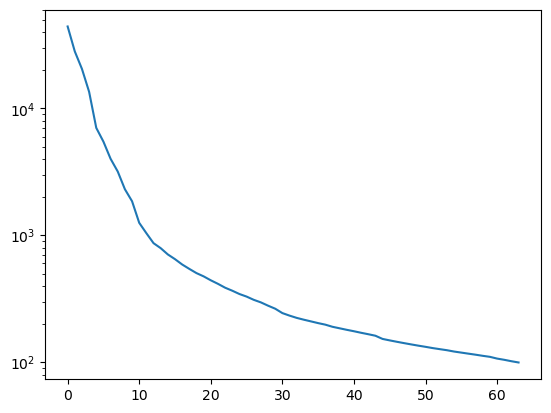

In [82]:
np.save('conv64_2',conv)
plt.plot(conv)
plt.yscale('log')

In [ ]:
0) gammah=array(0.9987186, dtype=float32), err=4.14848e+03
1) gammah=array(0.8121299, dtype=float32), err=1.50090e+03
2) gammah=array(1.1571777, dtype=float32), err=8.29512e+02
3) gammah=array(1.4420248, dtype=float32), err=5.39641e+02
4) gammah=array(1.1165022, dtype=float32), err=3.90272e+02
5) gammah=array(1.6383797, dtype=float32), err=2.91430e+02